# Multiple Regression Analysis Notebook

This notebook performs multiple regression analysis on fields in a dataset.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

## Step 1: Load the file and clean the data

In [2]:
# Replace 'your_dataset.csv' with the path to your dataset
file1_path = 'datasets/Student Engagement Level-Binary.csv'
file2_path = 'datasets/Student Performance Prediction-Multi.csv'
data1 = pd.read_csv(file1_path)
data2 = pd.read_csv(file2_path)

# Display the first few rows of the dataset
print("Dataset 1:")
display(data1.head())
print("\nDataset 2:")
display(data2.head())

join_field = 'Student ID'  # Specify the column used for joining

# Perform the join
merged_data = pd.merge(data1, data2, on=join_field, how='inner')

print("\nMerged Dataset:")
display(merged_data.head())

Dataset 1:


,Student ID,# Logins,# Content Reads,# Forum Reads,# Forum Posts,# Quiz Reviews before submission,Assignment 1 lateness indicator,Assignment 2 lateness indicator,Assignment 3 lateness indicator,Assignment 1 duration to submit (in hours),Assignment 2 duration to submit (in hours),Assignment 3 duration to submit (in hours),Average time to submit assignment (in hours),Engagement Level
0,student000000,143,344,58,0,3,0,0,0,178.166667,92.716667,116.166667,129.016667,H
1,student000001,70,342,0,0,4,0,0,0,294.033333,196.083333,217.750000,235.955556,L
2,student000002,42,219,0,0,3,0,0,0,169.600000,235.733333,260.333333,221.888889,L
3,student000003,92,271,2,0,6,0,0,0,341.150000,245.900000,271.216667,286.088889,L
4,student000004,116,379,0,0,1,0,0,0,325.500000,236.283333,260.733333,274.172222,L



Dataset 2:


,Student ID,Quiz01 [10],Assignment01 [8],Midterm Exam [20],Assignment02 [12],Assignment03 [25],Final Exam [35],Course Grade,Total [100],Class
0,student000000,95,91,70,90,84,64,85,85,G
1,student000001,85,76,65,61,73,64,76,76,G
2,student000002,85,41,73,61,73,61,73,73,G
3,student000003,80,78,80,79,79,57,80,79,G
4,student000004,85,91,78,80,84,67,85,85,G



Merged Dataset:


,Student ID,# Logins,# Content Reads,# Forum Reads,# Forum Posts,# Quiz Reviews before submission,Assignment 1 lateness indicator,Assignment 2 lateness indicator,Assignment 3 lateness indicator,Assignment 1 duration to submit (in hours),...,Engagement Level,Quiz01 [10],Assignment01 [8],Midterm Exam [20],Assignment02 [12],Assignment03 [25],Final Exam [35],Course Grade,Total [100],Class
0,student000000,143,344,58,0,3,0,0,0,178.166667,...,H,95,91,70,90,84,64,85,85,G
1,student000001,70,342,0,0,4,0,0,0,294.033333,...,L,85,76,65,61,73,64,76,76,G
2,student000002,42,219,0,0,3,0,0,0,169.600000,...,L,85,41,73,61,73,61,73,73,G
3,student000003,92,271,2,0,6,0,0,0,341.150000,...,L,80,78,80,79,79,57,80,79,G
4,student000004,116,379,0,0,1,0,0,0,325.500000,...,L,85,91,78,80,84,67,85,85,G


## Step 2: Specify variables and perform Cross-Validation

In [3]:
# Define the target and predictors
target = 'Course Grade'  # Replace with your target column
features = ["# Logins", "# Content Reads", "# Forum Reads", "# Forum Posts", "# Quiz Reviews before submission",
              "Assignment 1 duration to submit (in hours)", "Assignment 2 duration to submit (in hours)", "Assignment 3 duration to submit (in hours)", 
              "Average time to submit assignment (in hours)"]  # Replace with your predictor columns

X = merged_data[features]
y = merged_data[target]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Lasso with Cross-Validation to find the best alpha
lasso_cv = LassoCV(alphas=np.logspace(-4, 1, 50), cv=10, random_state=42)
lasso_cv.fit(X_train, y_train)

# Best alpha
best_alpha = lasso_cv.alpha_
print(f"Best alpha: {best_alpha:.5f}")

Best alpha: 0.59636


## Step 3: Run Lasso Regression

In [4]:
# Train final Lasso model with best alpha
lasso = Lasso(alpha=best_alpha)
lasso.fit(X_train, y_train)

# Predictions
y_pred = lasso.predict(X_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.5f}")
print(f"R-squared (R²): {r2:.5f}")

# Coefficients
coef_df = pd.DataFrame({'Feature': ['Intercept'] + features, 'Coefficient': [lasso.intercept_] + list(lasso.coef_)})
print("\nLasso Coefficients:")
print(coef_df)

Mean Squared Error (MSE): 92.57024
R-squared (R²): 0.12374

Lasso Coefficients:
                                        Feature  Coefficient
0                                     Intercept    80.166396
1                                      # Logins     1.578623
2                               # Content Reads     1.078126
3                                 # Forum Reads    -0.000000
4                                 # Forum Posts     0.315460
5              # Quiz Reviews before submission     0.688771
6    Assignment 1 duration to submit (in hours)    -0.749569
7    Assignment 2 duration to submit (in hours)     0.000000
8    Assignment 3 duration to submit (in hours)    -3.021506
9  Average time to submit assignment (in hours)    -0.000000


## Step 4: Plot feature importance

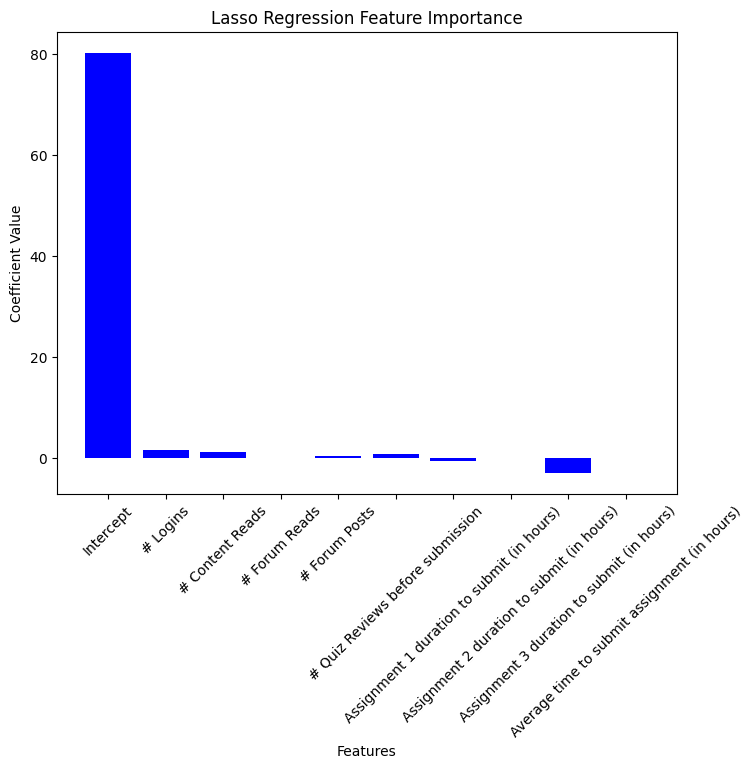

In [5]:
# Plot feature importance
plt.figure(figsize=(8, 6))
plt.bar(coef_df['Feature'], coef_df['Coefficient'], color='blue')
plt.xlabel("Features")
plt.ylabel("Coefficient Value")
plt.title("Lasso Regression Feature Importance")
plt.xticks(rotation=45)
plt.show()